In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # thêm import này để vẽ biểu đồ

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_recall_fscore_support,
)

In [18]:
DATA_DIR = "datasets/"

student_info = pd.read_csv(
    DATA_DIR + "studentInfo.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "final_result",
        "gender",
        "region",
        "age_band",
        "highest_education",
        "imd_band",
        "num_of_prev_attempts",
        "studied_credits",
        "disability",
    ],
)

student_reg = pd.read_csv(
    DATA_DIR + "studentRegistration.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "date_registration",
        "date_unregistration",
    ],
)

student_vle = pd.read_csv(
    DATA_DIR + "studentVle.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "id_site",
        "date",
        "sum_click",
    ],
)

student_ass = pd.read_csv(
    DATA_DIR + "studentAssessment.csv",
    usecols=[
        "id_assessment",
        "id_student",
        "date_submitted",
        "is_banked",
        "score",
    ],
)

In [19]:
MODULE = "EEE"
PRESENTATION = "2014J"
EARLY_DAYS = 14  # chỉ dùng 14 ngày đầu cho early-warning

students = student_info[
    (student_info["code_module"] == MODULE)
    & (student_info["code_presentation"] == PRESENTATION)
].copy()

# Label: Withdrawn = dropout (1), còn lại = 0
students["dropout"] = np.where(students["final_result"] == "Withdrawn", 1, 0)

print("Số lượng sinh viên:", len(students))
print("Tỉ lệ dropout:", students["dropout"].mean())

Số lượng sinh viên: 1188
Tỉ lệ dropout: 0.25757575757575757


In [20]:
reg = student_reg[
    (student_reg["code_module"] == MODULE)
    & (student_reg["code_presentation"] == PRESENTATION)
    & (student_reg["id_student"].isin(students["id_student"]))
].copy()

reg_features = reg[["id_student", "date_registration"]].copy()
reg_features = reg_features.rename(columns={"date_registration": "reg_day"})
reg_features["registered_before_start"] = (reg_features["reg_day"] < 0).astype(int)

In [21]:
vle = student_vle[
    (student_vle["code_module"] == MODULE)
    & (student_vle["code_presentation"] == PRESENTATION)
    & (student_vle["id_student"].isin(students["id_student"]))
    & (student_vle["date"] >= 0)
    & (student_vle["date"] <= EARLY_DAYS)
].copy()

# 4.1 Tổng quan hoạt động
vle_agg = (
    vle.groupby("id_student")
    .agg(
        total_clicks=("sum_click", "sum"),
        active_days=("date", "nunique"),
    )
    .reset_index()
)

vle_agg["avg_clicks_per_day"] = vle_agg["total_clicks"] / EARLY_DAYS
vle_agg["avg_clicks_per_active_day"] = (
    vle_agg["total_clicks"] / vle_agg["active_days"].replace(0, np.nan)
)
vle_agg["avg_clicks_per_active_day"] = vle_agg["avg_clicks_per_active_day"].fillna(0)

# 4.2 Click theo từng giai đoạn (0–7, 8–14)
def clicks_in_window(df, start_day, end_day, col_name):
    w = (
        df[(df["date"] >= start_day) & (df["date"] <= end_day)]
        .groupby("id_student")["sum_click"]
        .sum()
        .reset_index()
        .rename(columns={"sum_click": col_name})
    )
    return w

w1 = clicks_in_window(vle, 0, 7, "clicks_0_7")
w2 = clicks_in_window(vle, 8, EARLY_DAYS, "clicks_8_14")

for w in [w1, w2]:
    vle_agg = vle_agg.merge(w, on="id_student", how="left")

vle_agg = vle_agg.fillna(0)

# 4.3 days_since_last_login & inactivity_streak trong 14 ngày
last_active = (
    vle.groupby("id_student")["date"]
    .max()
    .reset_index()
    .rename(columns={"date": "last_active_day"})
)
last_active["days_since_last_login"] = EARLY_DAYS - last_active["last_active_day"]

vle_days = (
    vle.groupby("id_student")["date"]
    .apply(lambda x: sorted(x.unique()))
    .reset_index()
    .rename(columns={"date": "active_days_list"})
)

def compute_inactivity_streak(days_list, max_day):
    if not days_list:
        return max_day + 1
    active_set = set(days_list)
    streak = 0
    current_day = max_day
    while current_day >= 0 and current_day not in active_set:
        streak += 1
        current_day -= 1
    return streak

vle_days["inactivity_streak"] = vle_days["active_days_list"].apply(
    lambda lst: compute_inactivity_streak(lst, EARLY_DAYS)
)

extra_activity = last_active[["id_student", "days_since_last_login"]].merge(
    vle_days[["id_student", "inactivity_streak"]], on="id_student", how="outer"
)

vle_agg = vle_agg.merge(extra_activity, on="id_student", how="left")


In [22]:
ass = student_ass[
    (student_ass["id_student"].isin(students["id_student"]))
    & (student_ass["date_submitted"] >= 0)
    & (student_ass["date_submitted"] <= EARLY_DAYS)
].copy()

ass_agg = (
    ass.groupby("id_student")
    .agg(
        num_assessments=("id_assessment", "nunique"),
        avg_score=("score", "mean"),
        max_score=("score", "max"),
        min_score=("score", "min"),
        score_std=("score", "std"),
    )
    .reset_index()
)

last_score = (
    ass.sort_values(["id_student", "date_submitted"])
    .groupby("id_student")["score"]
    .last()
    .reset_index()
    .rename(columns={"score": "last_score"})
)

ass_agg = ass_agg.merge(last_score, on="id_student", how="left")

PASS_THRESHOLD = 40
ass["is_pass"] = (ass["score"] >= PASS_THRESHOLD).astype(int)

pass_rate = (
    ass.groupby("id_student")["is_pass"]
    .mean()
    .reset_index()
    .rename(columns={"is_pass": "pass_rate"})
)

ass_agg = ass_agg.merge(pass_rate, on="id_student", how="left")
ass_agg = ass_agg.fillna(0)

In [23]:
data = (
    students.merge(reg_features, on="id_student", how="left")
    .merge(vle_agg, on="id_student", how="left")
    .merge(ass_agg, on="id_student", how="left")
)

numeric_cols_to_fill = [
    "reg_day",
    "registered_before_start",
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "avg_clicks_per_active_day",
    "clicks_0_7",
    "clicks_8_14",
    "num_assessments",
    "avg_score",
    "max_score",
    "min_score",
    "score_std",
    "last_score",
    "days_since_last_login",
    "inactivity_streak",
    "pass_rate",
]

for col in numeric_cols_to_fill:
    if col in data.columns:
        data[col] = data[col].fillna(0)

print("NaN còn lại:")
print(data.isna().sum())


NaN còn lại:
code_module                   0
code_presentation             0
id_student                    0
gender                        0
region                        0
highest_education             0
imd_band                     47
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
dropout                       0
reg_day                       0
registered_before_start       0
total_clicks                  0
active_days                   0
avg_clicks_per_day            0
avg_clicks_per_active_day     0
clicks_0_7                    0
clicks_8_14                   0
days_since_last_login         0
inactivity_streak             0
num_assessments               0
avg_score                     0
max_score                     0
min_score                     0
score_std                     0
last_score                    0
pass_rate                     0
dtype: int64


In [24]:
feature_cols_num = [
    # Hoạt động
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "avg_clicks_per_active_day",
    "clicks_0_7",
    "clicks_8_14",
    # Quiz / điểm số
    "num_assessments",
    "avg_score",
    "max_score",
    "min_score",
    "score_std",
    "last_score",
    "pass_rate",
    # Thời gian & gián đoạn
    "reg_day",
    "registered_before_start",
    "days_since_last_login",
    "inactivity_streak",
]

feature_cols_cat = [
    "gender",
    "age_band",
]

X = data[feature_cols_num + feature_cols_cat]
y = data["dropout"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("Shape train/test:", X_train.shape, X_test.shape)
print("Dropout ratio train/test:", y_train.mean(), y_test.mean())


Shape train/test: (831, 19) (357, 19)
Dropout ratio train/test: 0.2575210589651023 0.25770308123249297


In [25]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

In [26]:
models = {
    "LogisticRegression": LogisticRegression(
        penalty="l1",
        solver="saga",
        tol=1e-4,
        max_iter=1200,
    ),
    "RandomForest": RandomForestClassifier(
        criterion="gini",
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=50,
        n_estimators=50,
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.03,
        max_depth=3,
        min_samples_split=20,
        n_estimators=10,
        n_iter_no_change=10,
    ),
    "MLPClassifier": MLPClassifier(
        alpha=0.1,
        early_stopping=True,
        hidden_layer_sizes=(135,),
        learning_rate="constant",
        learning_rate_init=0.3,
        max_iter=1200,
        momentum=0.9,
        solver="sgd",
    ),
}



In [30]:

results = {}

for name, clf in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("classifier", clf),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision_1, recall_1, f1_1, support_1 = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average=None
    )
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

   

    results[name] = {
        "accuracy": accuracy,
        "precision_1": precision_1[0],
        "recall_1": recall_1[0],
        "f1_1": f1_1[0],
        "roc_auc": roc_auc,
        "avg_precision": avg_prec,
        "support_1": support_1[0],
    }

results_df = pd.DataFrame(results).T
results_df


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision_1,recall_1,f1_1,roc_auc,avg_precision,support_1
LogisticRegression,0.820728,0.780000,0.423913,0.549296,0.797990,0.691868,92.0
RandomForest,0.809524,0.750000,0.391304,0.514286,0.798216,0.674967,92.0
GradientBoosting,0.742297,0.000000,0.000000,0.000000,0.786833,0.648895,92.0
MLPClassifier,0.817927,0.707692,0.500000,0.585987,0.809147,0.699701,92.0


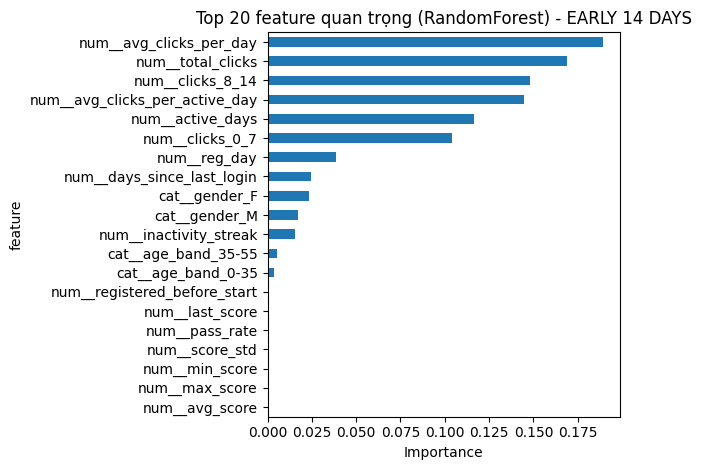

In [28]:
rf_clf = RandomForestClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=50,
    n_estimators=50,
)
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", rf_clf),
    ]
)
rf_pipe.fit(X_train, y_train)

feature_names = rf_pipe.named_steps["preprocess"].get_feature_names_out()
importances = rf_pipe.named_steps["classifier"].feature_importances_

fi = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

top_n = 20
plt.figure()
fi.head(top_n).set_index("feature")["importance"].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} feature quan trọng (RandomForest) - EARLY 14 DAYS")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [29]:
results = {}

for name,clf in models.items():
    
    pipe = Pipeline([
        ("prep",preprocessor),
        ("clf",clf),
    ])

    pipe.fit(X_train,y_train)

    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test,y_pred)
    prec,rec,f1,_ = precision_recall_fscore_support(
        y_test,y_pred,labels=[1]
    )
    auc = roc_auc_score(y_test,y_proba)
    avgp = average_precision_score(y_test,y_proba)

    results[name] = {
        "accuracy":acc,
        "precision":prec[0],
        "recall":rec[0],
        "f1":f1[0],
        "roc_auc":auc,
        "avg_precision":avgp,
    }

results_df = pd.DataFrame(results).T
results_df


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision,recall,f1,roc_auc,avg_precision
LogisticRegression,0.820728,0.780000,0.423913,0.549296,0.797990,0.691868
RandomForest,0.815126,0.795455,0.380435,0.514706,0.798831,0.672323
GradientBoosting,0.742297,0.000000,0.000000,0.000000,0.783142,0.653231
MLPClassifier,0.795518,0.952381,0.217391,0.353982,0.801559,0.688708
